In [11]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')

from models.fc_pytorch import FCNetworkPyTorch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.9.1+cpu


In [12]:
# Cell 2: Load data with DataLoader
import os

# Environment detection
LOCAL_MODE = not (os.path.exists('/content') or 'COLAB_GPU' in os.environ)

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load datasets
train_dataset = datasets.MNIST('../data/raw', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data/raw', train=False, download=True, transform=transform)

# Use subset locally
if LOCAL_MODE:
    train_dataset = torch.utils.data.Subset(train_dataset, range(60000))
    test_dataset = torch.utils.data.Subset(test_dataset, range(10000))
    print(f"LOCAL MODE: {len(train_dataset)} train, {len(test_dataset)} test")
else:
    print(f"FULL MODE: {len(train_dataset)} train, {len(test_dataset)} test")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Test batches: {len(test_loader)}")

LOCAL MODE: 60000 train, 10000 test
✓ Train batches: 938
✓ Test batches: 10


In [13]:
# Cell 3: Initialize model, loss, optimizer
model = FCNetworkPyTorch(
    input_size=784,
    hidden_sizes=[256, 128,64],
    num_classes=10,
    dropout=0.2
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model architecture:
FCNetworkPyTorch(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)

Total parameters: 242,762


In [14]:
# Cell 4: Training and evaluation functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Flatten images and move to device
        images = images.view(-1, 784).to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(train_loader), 100 * correct / total

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 784).to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

print("✓ Training functions ready")

✓ Training functions ready


In [15]:
# Cell 5: Train
num_epochs =10 if LOCAL_MODE else 15

train_losses = []
train_accs = []
test_accs = []

print("Training PyTorch model...")
print("=" * 60)

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_acc = evaluate(model, test_loader, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(epoch, train_loss, train_acc, test_acc)

Training PyTorch model...
0 0.33314476525192577 89.75833333333334 96.14
1 0.15348836815437433 95.56666666666666 96.46
2 0.11521176390373694 96.58833333333334 97.53
3 0.10000339388472042 97.04333333333334 97.1
4 0.08767633453217039 97.44666666666667 97.48
5 0.07407495799746965 97.77333333333333 97.75
6 0.07298580453091208 97.795 97.77
7 0.06443094149982033 98.07333333333334 97.84
8 0.05934357883292995 98.145 97.73
9 0.058599528634604485 98.19333333333333 98.16


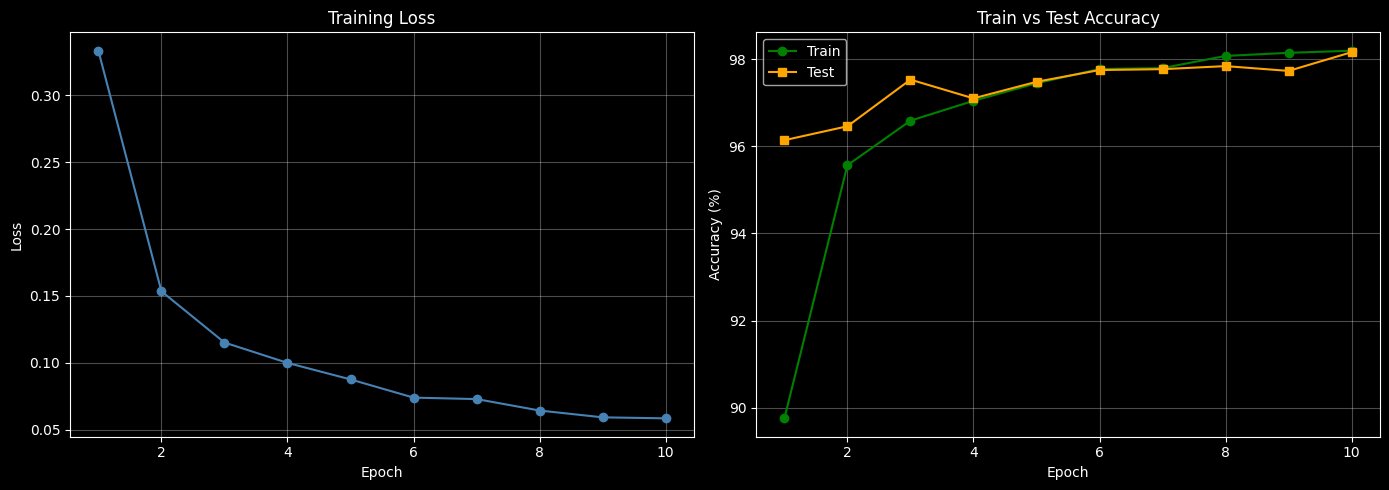

Best test accuracy: 98.16%


In [16]:
# Cell 6: Plot training curves
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
ax1.plot(range(1, num_epochs + 1), train_losses, marker='o', color='steelblue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(range(1, num_epochs + 1), train_accs, marker='o', label='Train', color='green')
ax2.plot(range(1, num_epochs + 1), test_accs, marker='s', label='Test', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Train vs Test Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best test accuracy: {max(test_accs):.2f}%")